In [4]:
pip install hmmlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 1.1 MB/s eta 0:00:00


In [17]:
import math
import numpy as np
from cv2 import Rodrigues
from math import sin, cos, atan2, sqrt
import pandas as pd
from pathlib import Path
import pyproj
from pyproj import Proj, transform
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from tqdm import tqdm
from hmmlearn import hmm
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings("ignore", category=Warning)

In [11]:
data = pd.read_csv("Gia SMP va SMPcap 2021(Giá thị trường SMP).csv",encoding='ISO-8859-1',sep=';')
data

,Ngày,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,01/01/2021,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4
1,01/02/2021,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,...,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7
2,01/03/2021,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,...,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4
3,01/04/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.1,...,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8
4,01/05/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,27/12/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,...,1002.1,1002.1,1002.1,1002.1,1002.1,1002.1,1002.1,1002.1,1002.0,1002.0
361,28/12/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,...,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0
362,29/12/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5
363,30/12/2021,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,...,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6


In [13]:
msv = 2151264647
col1 = msv%16 + 1
col2 = col1 + 1
col3 = col2 +1
df = data[[str(col1),str(col2),str(col3)]]
df['date'] = data['Ngày']
df.head(5)

,8,9,10,date
0,964.4,964.4,964.4,01/01/2021
1,1019.7,1019.7,1019.7,01/02/2021
2,988.4,988.4,988.4,01/03/2021
3,1002.0,1002.1,1002.1,01/04/2021
4,1061.5,1061.5,1061.5,01/05/2021


In [15]:
pip install pykalman

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 3.5 MB/s eta 0:00:00


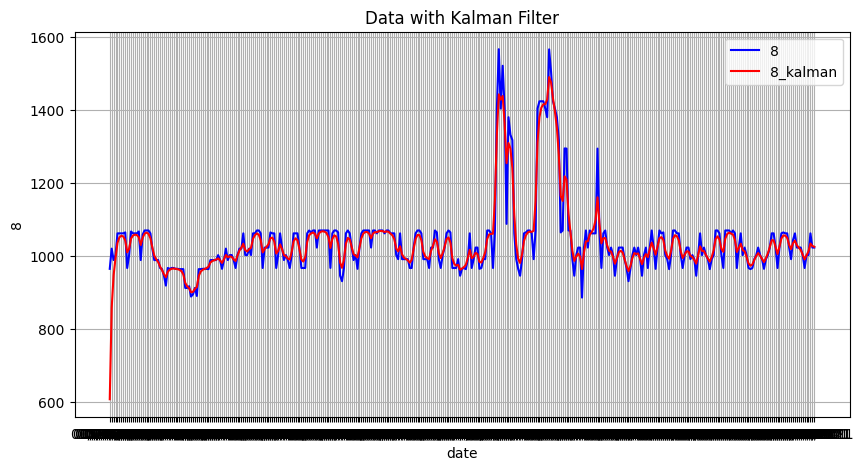

In [18]:
from pykalman import KalmanFilter
# Khởi tạo bộ lọc Kalman
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

# Áp dụng bộ lọc Kalman cho từng cột dữ liệu
df[f'{col1}_kalman'] = kf.smooth(df[str(col1)].values)[0]
df[f'{col2}_kalman'] = kf.smooth(df[str(col2)].values)[0]
df[f'{col3}_kalman'] = kf.smooth(df[str(col3)].values)[0]

# Trực quan hóa kết quả sau khi áp dụng bộ lọc Kalman
fig, ax = plt.subplots(figsize = (10,5))
sns.lineplot(ax=ax, data=df, x="date", y=str(col1), label=col1, color ='b')
sns.lineplot(ax=ax, data=df, x="date", y=f'{col1}_kalman', label=f'{col1}_kalman', color ='r')
plt.title('Data with Kalman Filter')
plt.legend()
plt.grid(True)
plt.show()

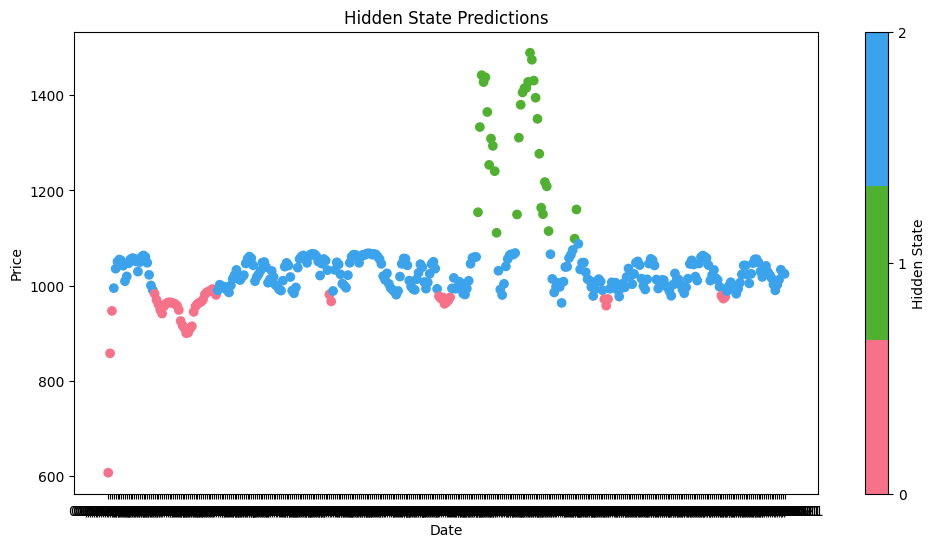

In [21]:
# Chọn cột dữ liệu đã được lọc bằng bộ lọc Kalman
kalman_cols = [f'{col1}_kalman', f'{col2}_kalman', f'{col3}_kalman']
kalman_data = df[kalman_cols]

# Khởi tạo mô hình HMM với 3 trạng thái ẩn
model = hmm.GaussianHMM(n_components=3, covariance_type='diag', n_iter=1000)

# Huấn luyện mô hình với dữ liệu đã được lọc
model.fit(kalman_data)

# Dự đoán trạng thái ẩn cho dữ liệu
hidden_states = model.predict(kalman_data)

# Thêm cột trạng thái ẩn vào DataFrame
df['hidden_state'] = hidden_states

# Trực quan hóa kết quả dự đoán
plt.figure(figsize=(12, 6))
cmap = ListedColormap(sns.color_palette("husl", 3))
plt.scatter(df['date'], df[kalman_cols[0]], c=df['hidden_state'], cmap=cmap)
plt.title('Hidden State Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.colorbar(ticks=[0, 1, 2], label='Hidden State')
plt.show()


In [22]:
print("Start probabilities: ", model.startprob_)
print("Transition matrix: ", model.transmat_)
print("Means: ", model.means_)
print("Covariances: ", model.covars_)


Start probabilities:  [1.00000000e+000 1.70048285e-287 0.00000000e+000]
Transition matrix:  [[8.73185970e-01 2.54918410e-50 1.26814030e-01]
 [2.25549682e-50 9.03873017e-01 9.61269829e-02]
 [2.02671868e-02 1.07092310e-02 9.69023582e-01]]
Means:  [[ 952.57043867  952.57106225  952.56961284]
 [1301.79098095 1301.79097991 1301.79097991]
 [1025.4488019  1025.51341506 1025.51333083]]
Covariances:  [[[ 3040.15232864     0.             0.        ]
  [    0.          3040.11162501     0.        ]
  [    0.             0.          3040.04430658]]

 [[14798.84427419     0.             0.        ]
  [    0.         14798.84440514     0.        ]
  [    0.             0.         14798.84440515]]

 [[  708.11184495     0.             0.        ]
  [    0.           709.32504744     0.        ]
  [    0.             0.           709.33036128]]]


In [23]:
X, Z = model.sample(5)  # Lấy mẫu 5 quan sát mới
print("Sampled observations: ", X)
print("Sampled hidden states: ", Z)

Sampled observations:  [[1041.6861417   940.4165402  1007.20561725]
 [ 970.91872215  916.91809245  989.94605977]
 [ 940.90064765  974.20873736  953.1715134 ]
 [ 989.20627861  833.70026129  866.11649405]
 [ 983.90213271  932.48520087 1012.29075017]]
Sampled hidden states:  [0 0 0 0 0]
